In [1]:
import configargparse
import torch
import torch.optim as optim
import sys
sys.path.append('../')

from environments import MountainCarEnv, Continuous_MountainCarEnv
from models.agents import NFQAgent
from models.networks import NFQNetwork, ContrastiveNFQNetwork
from util import get_logger, close_logger, load_models, make_reproducible, save_models
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
import tqdm

In [2]:
def generate_data(init_experience=50, bg_only=False, continuous=False, agent=None, dataset='train'):
    if continuous:
        env_bg = Continuous_MountainCarEnv(group=0)
        env_fg = Continuous_MountainCarEnv(group=1)
    else:
        env_bg = MountainCarEnv(group=0)
        env_fg = MountainCarEnv(group=1)
    bg_rollouts = []
    fg_rollouts = []
    if init_experience > 0:
        for _ in range(init_experience):
            rollout_bg, episode_cost = env_bg.generate_rollout(
                agent, render=False, group=0, dataset=dataset
            )
            bg_rollouts.extend(rollout_bg)
            if not bg_only:
                rollout_fg, episode_cost = env_fg.generate_rollout(
                    agent, render=False, group=1, dataset=dataset
                )
                fg_rollouts.extend(rollout_fg)
    bg_rollouts.extend(fg_rollouts)
    all_rollouts = bg_rollouts.copy()
    return all_rollouts, env_bg, env_fg

# Continuous Mountaincar
* There are quite a few actions. This makes it hard for FQI to learn to succeed on this task. 

# Regular Mountaincar
* Has three actions, easier for FQI to understand what's going on. 

## Using random actions to generate rollout results in the agent never succeeding

/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

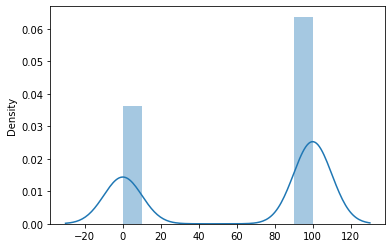

In [3]:
train_rollouts, train_env_bg, train_env_fg = generate_data(bg_only=True, continuous=False)
rewards = [r[2] for r in train_rollouts]
actions = [r[1] for r in train_rollouts]
sns.distplot(rewards, bins=10)

## Use a model to generate actions that are better than random
* This doesn't do well either without any adjustments. The model can't really learn how to make it past -0.4 position
* Even if we change the reward to be continuous, FQI can't learn it.
* However, we can make the reset speed 0.3, we sometimes learn it. 
* When we train a model, the reset has a speed of 0. 

In [4]:
is_contrastive=False
epoch = 10

train_rollouts, train_env_bg, train_env_fg = generate_data(bg_only=True, continuous=False, dataset='train')
test_rollouts, eval_env_bg, eval_env_fg = generate_data(bg_only=True, continuous=False, dataset='train')
nfq_net = ContrastiveNFQNetwork(
    state_dim=train_env_bg.state_dim, is_contrastive=is_contrastive, deep=True
)
optimizer = optim.Adam(nfq_net.parameters(), lr=1e-1)

nfq_agent = NFQAgent(nfq_net, optimizer)

# NFQ Main loop
bg_success_queue = [0] * 3
fg_success_queue = [0] * 3
epochs_fg = 0
eval_fg = 0
train_rewards = [r[2] for r in train_rollouts]
test_rewards = [r[2] for r in test_rollouts]
print("Average Train Reward: " + str(np.average(train_rewards)) + " Average Test Reward: " + str(np.average(test_rewards)))
for k, epoch in enumerate(tqdm.tqdm(range(epoch + 1))):
    state_action_b, target_q_values, groups = nfq_agent.generate_pattern_set(train_rollouts)

    if not nfq_net.freeze_shared:
        loss = nfq_agent.train((state_action_b, target_q_values, groups))

    eval_episode_length_fg, eval_success_fg, eval_episode_cost_fg = 0, 0, 0
    if nfq_net.freeze_shared:
        eval_fg += 1
        if eval_fg > 50:
            loss = nfq_agent.train((state_action_b, target_q_values, groups))

    (eval_episode_length_bg, eval_success_bg, eval_episode_cost_bg) = nfq_agent.evaluate_car(eval_env_bg, render=False)
    #(eval_episode_length_fg,eval_success_fg, eval_episode_cost_fg) = nfq_agent.evaluate_car(eval_env_fg, render=False)

    bg_success_queue = bg_success_queue[1:]
    bg_success_queue.append(1 if eval_success_bg else 0)

    #fg_success_queue = fg_success_queue[1:]
    #fg_success_queue.append(1 if eval_success_fg else 0)

    if sum(bg_success_queue) == 3 and not nfq_net.freeze_shared == True:
        if epochs_fg == 0:
            epochs_fg = epoch
        printed_bg = True
        nfq_net.freeze_shared = True
        if verbose:
            print("FREEZING SHARED")
        if is_contrastive:
            for param in nfq_net.layers_shared.parameters():
                param.requires_grad = False
            for param in nfq_net.layers_last_shared.parameters():
                param.requires_grad = False
            for param in nfq_net.layers_fg.parameters():
                param.requires_grad = True
            for param in nfq_net.layers_last_fg.parameters():
                param.requires_grad = True
        else:
            for param in nfq_net.layers_fg.parameters():
                param.requires_grad = False
            for param in nfq_net.layers_last_fg.parameters():
                param.requires_grad = False

            optimizer = optim.Adam(
                itertools.chain(
                    nfq_net.layers_fg.parameters(),
                    nfq_net.layers_last_fg.parameters(),
                ),
                lr=1e-1,
            )
            nfq_agent._optimizer = optimizer

    if sum(fg_success_queue) == 3:
        printed_fg = True
        break
    
    train_rollouts, train_env_bg, train_env_fg = generate_data(bg_only=True, continuous=False, agent=nfq_agent, dataset='train')
    test_rollouts, eval_env_bg, eval_env_fg = generate_data(bg_only=True, continuous=False, agent=nfq_agent, dataset='train')
    train_rewards = [r[2] for r in train_rollouts]
    test_rewards = [r[2] for r in test_rollouts]
    print("Average Train Reward: " + str(np.average(train_rewards)) + " Average Test Reward: " + str(np.average(test_rewards)))

  0%|          | 0/11 [00:00<?, ?it/s]

Average Train Reward: 63.36 Average Test Reward: 64.6


  9%|▉         | 1/11 [00:07<01:19,  7.97s/it]

Average Train Reward: 0.0 Average Test Reward: 0.24


 18%|█▊        | 2/11 [00:16<01:12,  8.00s/it]

Average Train Reward: 69.56 Average Test Reward: 69.76


 27%|██▋       | 3/11 [00:24<01:04,  8.01s/it]

Average Train Reward: 69.52 Average Test Reward: 70.12


 36%|███▋      | 4/11 [00:32<00:56,  8.03s/it]

Average Train Reward: 69.8 Average Test Reward: 69.6


 45%|████▌     | 5/11 [00:40<00:48,  8.05s/it]

Average Train Reward: 69.68 Average Test Reward: 69.56


 55%|█████▍    | 6/11 [00:48<00:40,  8.09s/it]

Average Train Reward: 70.08 Average Test Reward: 70.04


 64%|██████▎   | 7/11 [00:56<00:32,  8.11s/it]

Average Train Reward: 70.16 Average Test Reward: 69.88


 73%|███████▎  | 8/11 [01:04<00:24,  8.13s/it]

Average Train Reward: 69.88 Average Test Reward: 69.32


 82%|████████▏ | 9/11 [01:12<00:16,  8.14s/it]

Average Train Reward: 70.08 Average Test Reward: 69.76


 91%|█████████ | 10/11 [01:21<00:08,  8.14s/it]

Average Train Reward: 69.88 Average Test Reward: 70.36


100%|██████████| 11/11 [01:29<00:00,  8.10s/it]

Average Train Reward: 39.2 Average Test Reward: 40.8


/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

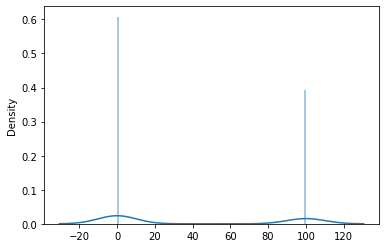

In [5]:
rewards = [r[2] for r in train_rollouts]
sns.distplot(rewards, bins=100)

## Train a new network with the result of better rollouts
* The evaluation is just changed to be regular resets (speed 0). 
* It doesn't really work. Even with the better 

In [10]:
test_rollouts, eval_env_bg, eval_env_fg = generate_data(bg_only=True, continuous=False, agent=nfq_agent, dataset='eval')
is_contrastive=False
epoch = 1000
nfq_net = ContrastiveNFQNetwork(
    state_dim=train_env_bg.state_dim, is_contrastive=is_contrastive, deep=False
)
optimizer = optim.Adam(nfq_net.parameters(), lr=1e-1)

nfq_agent = NFQAgent(nfq_net, optimizer)

bg_success_queue = [0] * 3
fg_success_queue = [0] * 3
epochs_fg = 0
eval_fg = 0
evaluations = 5
for k, ep in enumerate(tqdm.tqdm(range(epoch + 1))):
    state_action_b, target_q_values, groups = nfq_agent.generate_pattern_set(train_rollouts)

    if not nfq_net.freeze_shared:
        loss = nfq_agent.train((state_action_b, target_q_values, groups))

    eval_episode_length_fg, eval_success_fg, eval_episode_cost_fg = 0, 0, 0
    if nfq_net.freeze_shared:
        eval_fg += 1
        if eval_fg > 50:
            loss = nfq_agent.train((state_action_b, target_q_values, groups))

    (eval_episode_length_bg, eval_success_bg, eval_episode_cost_bg) = nfq_agent.evaluate_car(eval_env_bg, render=False)
    bg_success_queue = bg_success_queue[1:]
    bg_success_queue.append(1 if eval_success_bg else 0)

    if sum(bg_success_queue) == 3 and not nfq_net.freeze_shared == True:
        if epochs_fg == 0:
            epochs_fg = epoch
        printed_bg = True
        nfq_net.freeze_shared = True
        if verbose:
            print("FREEZING SHARED")
        if is_contrastive:
            for param in nfq_net.layers_shared.parameters():
                param.requires_grad = False
            for param in nfq_net.layers_last_shared.parameters():
                param.requires_grad = False
            for param in nfq_net.layers_fg.parameters():
                param.requires_grad = True
            for param in nfq_net.layers_last_fg.parameters():
                param.requires_grad = True
        else:
            for param in nfq_net.layers_fg.parameters():
                param.requires_grad = False
            for param in nfq_net.layers_last_fg.parameters():
                param.requires_grad = False

            optimizer = optim.Adam(
                itertools.chain(
                    nfq_net.layers_fg.parameters(),
                    nfq_net.layers_last_fg.parameters(),
                ),
                lr=1e-1,
            )
            nfq_agent._optimizer = optimizer
        break
    
    if ep % 100 == 0:
        for it in range(evaluations):
            (eval_episode_length_bg,eval_success_bg,eval_episode_cost_bg) = nfq_agent.evaluate_car(eval_env_bg, render=False)
            print(eval_episode_length_bg, eval_success_bg, eval_episode_cost_bg)
            train_env_bg.close()
            eval_env_bg.close()

  0%|          | 0/1001 [00:00<?, ?it/s]

0 False 0
0 False 0
0 False 0
0 False 0


  0%|          | 2/1001 [00:00<10:16,  1.62it/s]

0 False 0


 10%|▉         | 100/1001 [00:15<02:11,  6.84it/s]

0 False 0
0 False 0
0 False 0
0 False 0


 10%|█         | 102/1001 [00:16<04:17,  3.49it/s]

0 False 0


 20%|█▉        | 200/1001 [00:30<01:55,  6.91it/s]

0 False 0
0 False 0
0 False 0
0 False 0


 20%|██        | 202/1001 [00:31<03:48,  3.50it/s]

0 False 0


 30%|██▉       | 300/1001 [00:45<01:42,  6.82it/s]

0 False 0
0 False 0
0 False 0
0 False 0


 30%|███       | 302/1001 [00:46<03:20,  3.49it/s]

0 False 0


 40%|███▉      | 400/1001 [01:01<01:27,  6.86it/s]

0 False 0
0 False 0
0 False 0
0 False 0


 40%|████      | 402/1001 [01:02<02:51,  3.49it/s]

0 False 0


 50%|████▉     | 500/1001 [01:16<01:13,  6.82it/s]

0 False 0
0 False 0
0 False 0
0 False 0


 50%|█████     | 502/1001 [01:17<02:23,  3.49it/s]

0 False 0


 60%|█████▉    | 600/1001 [01:31<00:57,  6.92it/s]

0 False 0
0 False 0
0 False 0
0 False 0


 60%|██████    | 602/1001 [01:32<01:54,  3.50it/s]

0 False 0


 70%|██████▉   | 700/1001 [01:46<00:44,  6.82it/s]

0 False 0
0 False 0


 70%|███████   | 701/1001 [01:47<01:43,  2.89it/s]

0 False 0
0 False 0
0 False 0


 80%|███████▉  | 800/1001 [02:02<00:28,  7.02it/s]

0 False 0
0 False 0
0 False 0
0 False 0


 80%|████████  | 802/1001 [02:03<00:56,  3.50it/s]

0 False 0


 90%|████████▉ | 900/1001 [02:17<00:14,  6.82it/s]

0 False 0
0 False 0
0 False 0
0 False 0


 90%|█████████ | 902/1001 [02:18<00:28,  3.52it/s]

0 False 0


100%|█████████▉| 1000/1001 [02:32<00:00,  6.76it/s]

0 False 0
0 False 0
0 False 0
0 False 0


100%|██████████| 1001/1001 [02:33<00:00,  6.51it/s]

0 False 0
